In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
!pip install -q ultralytics pycocotools fiftyone tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from pathlib import Path
import json
import random
import shutil
import os
from tqdm import tqdm
from PIL import Image
import math

#Loading data

In [5]:
DRIVE_BASE = Path('/content/drive/MyDrive/CE888-data-resit')
IMAGES_TRAIN_DIR = DRIVE_BASE / 'Images' / 'Train' / 'images'
IMAGES_TEST_DIR = DRIVE_BASE / 'Images' / 'Test' / 'images'
LABELS_TRAIN_JSON = DRIVE_BASE / 'Labels' / 'labels_train.json'
LABELS_TEST_SAMPLE_JSON = DRIVE_BASE / 'Labels' / 'labels_test_sample.json'

## Output dataset prepared for YOLO training

In [6]:
WORK_DIR = Path('/content/ce888_dataset')
if WORK_DIR.exists():
    print(f"Removing existing work dir {WORK_DIR} to start fresh")
    shutil.rmtree(WORK_DIR)
WORK_DIR.mkdir(parents=True)

print('Paths:')
print('Train images dir:', IMAGES_TRAIN_DIR)
print('Test images dir:', IMAGES_TEST_DIR)
print('Labels json:', LABELS_TRAIN_JSON)
print('Work dir:', WORK_DIR)

Removing existing work dir /content/ce888_dataset to start fresh
Paths:
Train images dir: /content/drive/MyDrive/CE888-data-resit/Images/Train/images
Test images dir: /content/drive/MyDrive/CE888-data-resit/Images/Test/images
Labels json: /content/drive/MyDrive/CE888-data-resit/Labels/labels_train.json
Work dir: /content/ce888_dataset


##  Read labels JSON (train labels)

In [7]:
with open(LABELS_TRAIN_JSON, 'r') as f:
    labels_json = json.load(f)

In [8]:
# Gathering image files
all_images = []
for p in IMAGES_TRAIN_DIR.glob('*'):
    if p.suffix.lower() in ['.jpg', '.jpeg', '.png']:
        all_images.append(p)
for p in IMAGES_TEST_DIR.glob('*'):
    if p.suffix.lower() in ['.jpg', '.jpeg', '.png']:
        all_images.append(p)

print('Total available images found:', len(all_images))

N = 1000
if len(all_images) < N:
    print(f"Warning: only {len(all_images)} images available, using all of them")
    N = len(all_images)

random.seed(42)
selected = random.sample(all_images, N)

Total available images found: 3009


## Creating dataset structure (YOLO format) and split

In [9]:
random.shuffle(selected)
train_n = int(0.8 * N)
val_n = int(0.1 * N)

train_imgs = selected[:train_n]
val_imgs = selected[train_n:train_n+val_n]
test_imgs = selected[train_n+val_n:]

print('Using images:', N, '-> train', len(train_imgs), 'val', len(val_imgs), 'test', len(test_imgs))

# Creating directories
images_dir = WORK_DIR / 'images'
labels_dir = WORK_DIR / 'labels'
for s in ['train', 'val', 'test']:
    (images_dir / s).mkdir(parents=True, exist_ok=True)
    (labels_dir / s).mkdir(parents=True, exist_ok=True)

Using images: 1000 -> train 800 val 100 test 100


## YOLO label file (one line per object: class x_center y_center width height)

In [10]:
def write_yolo_label(label_path: Path, objs):
    # objs is list of dicts with keys: class, x_center, y_center, width, height (already normalized)
    with open(label_path, 'w') as f:
        for obj in objs:
            cls = int(obj['class'])
            x = float(obj['x_center'])
            y = float(obj['y_center'])
            w = float(obj['width'])
            h = float(obj['height'])
            f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

# Copy images and write labels
from tqdm import tqdm

In [11]:
def process_and_copy(img_path: Path, subset: str):
    dest_img = images_dir / subset / img_path.name
    shutil.copy2(img_path, dest_img)
    stem = img_path.stem
    key = stem + '.txt'
    dest_label = labels_dir / subset / (img_path.stem + '.txt')
    if key in labels_json:
        objs = labels_json[key]['labels']
        write_yolo_label(dest_label, objs)
    else:

        dest_label.write_text('')

for p in tqdm(train_imgs, desc='copy train'):
    process_and_copy(p, 'train')
for p in tqdm(val_imgs, desc='copy val'):
    process_and_copy(p, 'val')
for p in tqdm(test_imgs, desc='copy test'):
    process_and_copy(p, 'test')

copy test: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


##  Preparing data.yaml for ultralytics YOLOv8

In [12]:
DATA_YAML = WORK_DIR / 'data.yaml'
num_classes = 4
names = ['Bistoury', 'Dissection_Forceps', 'Straight_Scissors', 'Curved_Scissor']

data_yaml = {
    'path': str(WORK_DIR),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': num_classes,
    'names': names
}
with open(DATA_YAML, 'w') as f:
    yaml_txt = json.dumps(data_yaml)
    f.write('path: "' + str(WORK_DIR) + '"\n')
    f.write('train: "images/train"\n')
    f.write('val: "images/val"\n')
    f.write('test: "images/test"\n')
    f.write(f'nc: {num_classes}\n')
    f.write('names: [')
    f.write(', '.join([f'"{n}"' for n in names]))
    f.write(']\n')

print('Wrote data.yaml ->', DATA_YAML)

Wrote data.yaml -> /content/ce888_dataset/data.yaml



# Training with ultralytics YOLOv8

In [13]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

# Training parameters
EPOCHS = 5
BATCH = 16
IMGSZ = 640

print('Starting training...')
model.train(data=str(DATA_YAML), epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH, name='ce888_yolov8n_run')
print('Training finished')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting training...
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ce888_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8

#  Validating on val set & evaluate mAP (@0.5:0.95)

In [14]:
print('Running validation...')
metrics = model.val(data=str(DATA_YAML), imgsz=IMGSZ)
print('Validation metrics:', metrics)

Running validation...
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1811.4±458.1 MB/s, size: 66.2 KB)
val: Scanning /content/ce888_dataset/labels/val.cache... 100 images, 73 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 199.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.9it/s 1.8s
                   all        100         38      0.111      0.447      0.132     0.0928
              Bistoury         11         11      0.124      0.545      0.187      0.135
    Dissection_Forceps          7          7     0.0962      0.286     0.0666      0.033
     Straight_Scissors          8          8     0.0985      0.375      0.142      0.108
        Curved_Scissor         12         12      0.125      0.583      0.134     0.0947
Speed: 4.0ms preprocess

In [15]:
#  Run inference on the test split and export predictions to JSON
print('Running inference on test set...')
results = model.predict(source=str(images_dir / 'test'), save=False, conf=0.25, imgsz=IMGSZ)

Running inference on test set...

image 1/100 /content/ce888_dataset/images/test/0ctbyh1mkq.jpg: 480x640 (no detections), 74.0ms
image 2/100 /content/ce888_dataset/images/test/18wcwr2fm1.jpg: 480x640 (no detections), 8.5ms
image 3/100 /content/ce888_dataset/images/test/1ij7ek0fwv.jpg: 480x640 (no detections), 7.6ms
image 4/100 /content/ce888_dataset/images/test/2lorbugiic.jpg: 480x640 (no detections), 12.5ms
image 5/100 /content/ce888_dataset/images/test/2r5stet0ma.jpg: 480x640 (no detections), 11.3ms
image 6/100 /content/ce888_dataset/images/test/2v4kqwdbdn.jpg: 480x640 (no detections), 9.5ms
image 7/100 /content/ce888_dataset/images/test/32c8eog64o.jpg: 480x640 (no detections), 8.1ms
image 8/100 /content/ce888_dataset/images/test/3dnlloy6u6.jpg: 480x640 (no detections), 8.2ms
image 9/100 /content/ce888_dataset/images/test/3pi2ok0os8.jpg: 480x640 1 Curved_Scissor, 8.0ms
image 10/100 /content/ce888_dataset/images/test/3tl5fcj2kx.jpg: 480x640 (no detections), 8.1ms
image 11/100 /content

# Building predictions JSON mapping filename

In [16]:
# Each detection: {class: int, x_center: float (norm), y_center: float, width: float, height: float, confidence: float}
from collections import defaultdict
preds = defaultdict(list)

for r in results:
    # r.path is the image path
    img_path = Path(r.path)
    img_w, img_h = Image.open(img_path).size
    boxes = r.boxes
    if boxes is None or len(boxes) == 0:
        preds[img_path.name] = []
        continue
    # boxes.xyxy, boxes.conf, boxes.cls
    xyxy = boxes.xyxy.cpu().numpy()  # N x 4
    confs = boxes.conf.cpu().numpy()
    clses = boxes.cls.cpu().numpy().astype(int)
    for i in range(len(confs)):
        x1, y1, x2, y2 = xyxy[i]
        bw = x2 - x1
        bh = y2 - y1
        x_c = x1 + bw / 2.0
        y_c = y1 + bh / 2.0
        # normalize
        xcn = x_c / img_w
        ycn = y_c / img_h
        bwn = bw / img_w
        bhn = bh / img_h
        preds[img_path.name].append({
            'class': int(clses[i]),
            'x_center': float(round(xcn, 6)),
            'y_center': float(round(ycn, 6)),
            'width': float(round(bwn, 6)),
            'height': float(round(bhn, 6)),
            'confidence': float(round(float(confs[i]), 6))
        })

# Saving predictions JSON to Drive
OUTPUT_JSON = DRIVE_BASE / 'predictions_ce888_test.json'
with open(OUTPUT_JSON, 'w') as f:
    json.dump(preds, f, indent=2)

print('Wrote predictions to', OUTPUT_JSON)

Wrote predictions to /content/drive/MyDrive/CE888-data-resit/predictions_ce888_test.json


# saving model

In [17]:
RUNS_DIR = Path('runs')

saved = False
for p in RUNS_DIR.rglob('weights/*.pt'):
    if 'ce888_yolov8n_run' in str(p):
        dest = DRIVE_BASE / p.name
        shutil.copy2(p, dest)
        print('Saved weights to', dest)
        saved = True
        break
if not saved:
    print('No weights found in runs/ - check training output to locate best.pt')


Saved weights to /content/drive/MyDrive/CE888-data-resit/best.pt


## Prediction visualisation

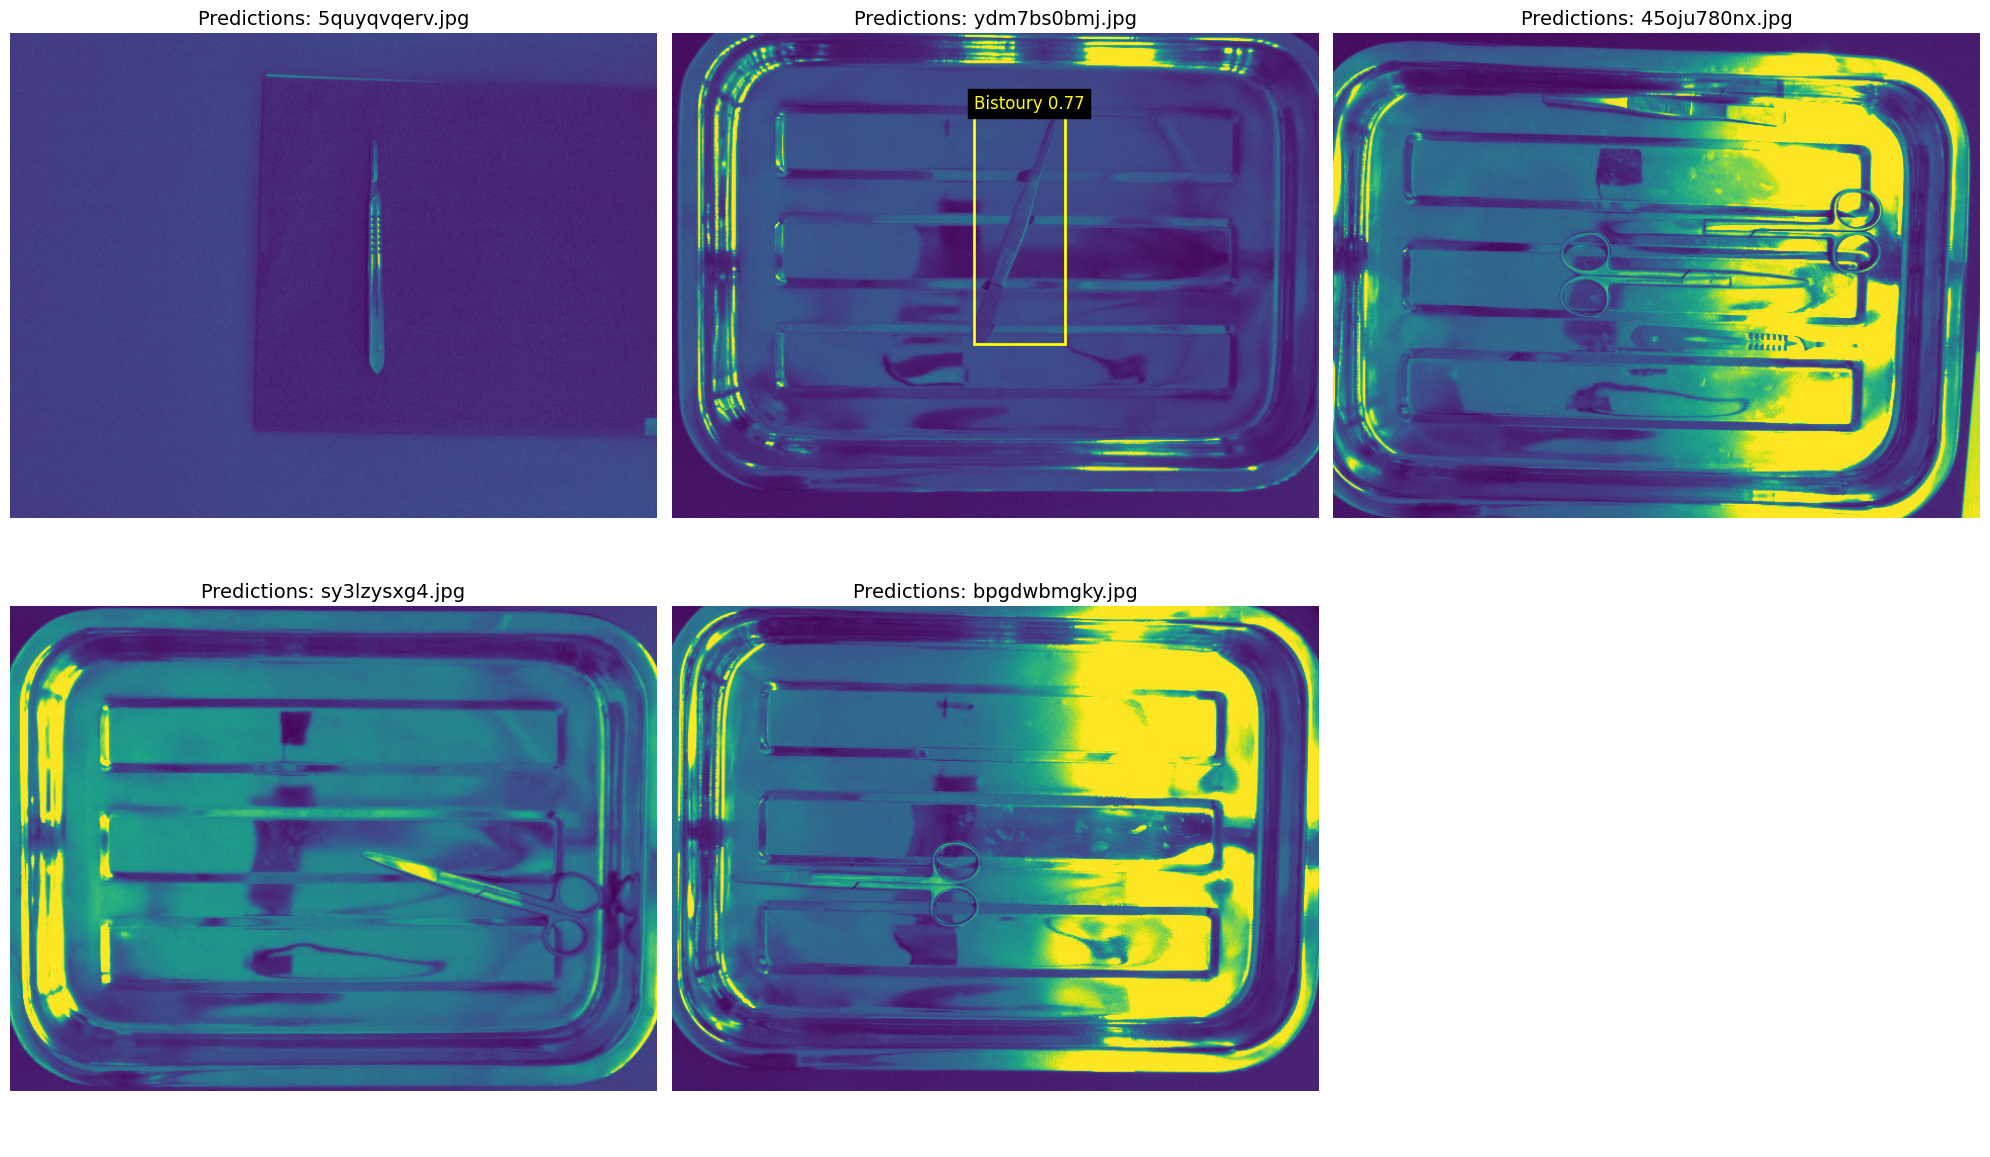

In [18]:
import random
import matplotlib.pyplot as plt
from PIL import Image

sample_images = random.sample(list(preds.keys()), min(5, len(preds)))

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, filename in enumerate(sample_images):
    img_path = images_dir / 'test' / filename
    img = Image.open(img_path)
    width, height = img.size

    axes[idx].imshow(img)

    # Draw predicted bounding boxes
    for det in preds[filename]:
        xc, yc, w, h = det['x_center'], det['y_center'], det['width'], det['height']
        conf = det['confidence']
        cls = det['class']
        label = names[cls]

        box_w = w * width
        box_h = h * height
        x1 = (xc * width) - (box_w / 2)
        y1 = (yc * height) - (box_h / 2)

        rect = plt.Rectangle((x1, y1), box_w, box_h, fill=False, linewidth=2, edgecolor='yellow')
        axes[idx].add_patch(rect)

        axes[idx].text(
            x1, y1, f"{label} {conf:.2f}",
            fontsize=12, color='yellow', backgroundcolor='black'
        )

    axes[idx].set_title(f"Predictions: {filename}", fontsize=14)
    axes[idx].axis("off")

if len(sample_images) < 6:
    axes[-1].axis("off")

plt.tight_layout()
plt.show()
